### Misc: Model Selection
Random Forest is almost always worth trying, although other models may be more suitable:
- deep learning is more suitable for _unstructured_ data (images, audios, text).
- collaborative filtering more suitable for reconmender systems

# Grocery Problem: reconstructing a large dataset

The dataset, being very large is also split into multiple csv files, which makes it a challenge to load.

##### Understanding the dataset
The dataset is a relational dataset:
contains independent variables (features) that map to the dependent variable (prediction target).
This is time series data, hence special care should be taken when processing and maintaining the order of time.

## Imports and setup environment

In [1]:
%load_ext autoreload
%autoreload

%matplotlib inline

In [2]:
import numpy as np
import matplotlib as plt

from fastai.imports import *
from fastai.structured import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.impute import SimpleImputer

import subprocess
import os
import gc

In [3]:
PATH = "data/groceries/"
!ls {PATH}

holidays_events.csv  sample_submission.csv  text.txt	      transactions.csv
items.csv	     stores.csv		    train.csv
oil.csv		     test.csv		    train_sample.csv


## Read Data
reading a large requires some tweaking to make work

##### Sampling the data
To determine the datatypes to use when processing the dataset ,we can sample the data using the unix command `shuf`.

```sh
head -n 1 {PATH}train.csv >{PATH}train_sample.csv
shuf {PATH}train.csv -n {sample_size}>>{PATH}train_sample.csv
```

> Typically, we do as much as we on a management sample before loading the full massive dataset

In [4]:
# compute the number of lines to read based on sample fraction
SAMPLE_FRAC = 1.0 # set to 0.1 to sample 10%. In this case we are using all data
n_train = sum(1 for line in open(f"{PATH}train.csv"))
sample_size = int(SAMPLE_FRAC * int(n_train))

print(f"Sampling training set to {sample_size} examples")

Sampling training set to 125497041 examples


We add a function to read the csv in chunks to give progress infomation

In [5]:
# read the csv at the given path using pandas into a dataframe
# read the csv with chunks of the given size n_chunk
# progress infomation is printed if progress is specified as true
# bar size controls the size of the progress bar
# use the given datatypes for each column dtypes if given
# Parses dates for the given columns in parse dates
def read_csv(path, n_chunk=128, progress=True, bar_size=60, dtypes=None, parse_dates=False):
    # find number of lines
    n_lines = sum([1 for l in open(path)])
    
    # read df chunks
    df_chunks = []
    n_read = 0
    for df_chunk in pd.read_csv(path, chunksize=n_chunk, dtype=dtypes, parse_dates=parse_dates):
        df_chunks.append(df_chunk)
        n_read += len(df_chunk)
        
        # display progress infomation
        if progress:
            completion_ratio = n_read / n_lines
            print("#" * int(completion_ratio * bar_size), 
                  " " * int((1-completion_ratio) * bar_size), " ", 
                  "{0:.2f}%".format(completion_ratio * 100.0))
    
    # recombine chunks into full dataframe
    df = pd.concat(df_chunks)
    return df
    

##### Data types optimisation
To reduce memory consumption and ensure we don't run out of memory, we use the smallest possible data type for each coloumn (that still fits all the values).

> Using a small datatype also allows you to leverage SIMD instructions and obtain some performance gains

In [6]:
# use the smallest possible data type for each colomn 

df_dtypes = {
    "id": "int64",
    "item_nbr":"int32",
    "store_nbr": "int8",
    "unit_sales":"float32",
    "onpromotion": "object"
}


CHUNK_FRAC = 1 / 100

# Actually read the data:
print("Reading training data...")
df_train = read_csv(f"{PATH}train.csv", 
                    n_chunk=int(sample_size * CHUNK_FRAC), 
                    dtypes=df_dtypes,
                    parse_dates=["date"])

print("Reading test data...")
df_test = read_csv(f"{PATH}test.csv", n_chunk=int(65536), dtypes=df_dtypes,parse_dates=["date"])

Reading training data...
                                                               1.00%
#                                                              2.00%
#                                                              3.00%
##                                                             4.00%
##                                                             5.00%
###                                                            6.00%
####                                                           7.00%
####                                                           8.00%
#####                                                          9.00%
#####                                                          10.00%
######                                                         11.00%
#######                                                        12.00%
#######                                                        13.00%
########                                                       14.00%
####

###################                                            33.06%
####################                                           35.00%
######################                                         36.94%
#######################                                        38.89%
########################                                       40.83%
#########################                                      42.78%
##########################                                     44.72%
###########################                                    46.67%
#############################                                  48.61%
##############################                                 50.55%
###############################                                52.50%
################################                               54.44%
#################################                              56.39%
##################################                             58.33%
####################

In [7]:
print(f"Training set: {len(df_train)} examples")
print(f"Test set: {len(df_test)} examples")

Training set: 125497040 examples
Test set: 3370464 examples


##### Read the additional metadata provided

In [8]:
# Holidays and events meta data
events_dtypes = {
    "type": "category",
    "locale": "category",
    "locale_name": "object",
    "description": "object",
    "transferred": "bool"
}
    
df_events = pd.read_csv(f"{PATH}holidays_events.csv", dtype=events_dtypes,
                        parse_dates=["date"])

# Oil prices
df_oil = pd.read_csv(f"{PATH}oil.csv", dtype={"dcoilwtico": "float32"},
                    parse_dates=["date"])

# Store information
stores_dtypes = {
    "store_nbr": "int32",
    "city": "category",
    "state": "category",
    "type": "category",
    "cluster": "int8"
}

df_stores = pd.read_csv(f"{PATH}stores.csv", dtype=stores_dtypes)

# Items Provided
items_dtypes = {
    "item_nbr": "int32",
    "family": "category",
    "class": "int16",
    "perishable": "int8"
}
df_items = pd.read_csv(f"{PATH}items.csv", dtype=items_dtypes)

## Explore dataset
Explore the using pandas

This is a relational dataset that maps from input features to target output feature `unit_sales`.

##### Training set
Lets take a look at the training set

In [9]:
print("Training set:")
%time df_train.sample(int(1e+5)).describe(include="all")

Training set:
CPU times: user 4.97 s, sys: 392 ms, total: 5.37 s
Wall time: 5.36 s


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
count,1.000000e+05,100000,100000.000000,1.000000e+05,100000.000000,82718
unique,NaN,1682,NaN,NaN,NaN,2
top,NaN,2017-05-13 00:00:00,NaN,NaN,NaN,False
freq,NaN,114,NaN,NaN,NaN,76327
first,NaN,2013-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2017-08-15 00:00:00,NaN,NaN,NaN,NaN
mean,6.267804e+07,NaN,27.468820,9.744394e+05,8.522415,NaN
std,3.621321e+07,NaN,16.299293,5.217100e+05,19.473991,NaN
min,4.560000e+02,NaN,1.000000,9.699500e+04,-2.000000,NaN
25%,3.131312e+07,NaN,12.000000,5.223830e+05,2.000000,NaN


The training has date time stamp, foreign keys that reference other dataframes (`store_nbr`, `item_nbr`), whether the item is on promotion. Finally it includes the prediction target (dependent variable) `unit_sales`

##### Test Set
Lets take a look at the test set

In [10]:
print("Test set:")
%time df_test.sample(int(1e+5)).describe(include="all")

Test set:
CPU times: user 164 ms, sys: 169 µs, total: 164 ms
Wall time: 162 ms


,id,date,store_nbr,item_nbr,onpromotion
count,1.000000e+05,100000,100000.00000,1.000000e+05,100000
unique,NaN,16,NaN,NaN,2
top,NaN,2017-08-17 00:00:00,NaN,NaN,False
freq,NaN,6396,NaN,NaN,94215
first,NaN,2017-08-16 00:00:00,NaN,NaN,NaN
last,NaN,2017-08-31 00:00:00,NaN,NaN,NaN
mean,1.271785e+08,NaN,27.50641,1.246962e+06,NaN
std,9.733288e+05,NaN,15.56238,5.906799e+05,NaN
min,1.254971e+08,NaN,1.00000,9.699500e+04,NaN
25%,1.263348e+08,NaN,14.00000,8.098820e+05,NaN


###### Detect if there missing data data (NAN)

In [11]:
print("Training Contains Nan:", df_train.isna().any())
print("Test contains Nan:", df_test.isna().any())

Training Contains Nan: id             False
date           False
store_nbr      False
item_nbr       False
unit_sales     False
onpromotion     True
dtype: bool
Test contains Nan: id             False
date           False
store_nbr      False
item_nbr       False
onpromotion    False
dtype: bool


Look like the `onpromotion` includes NANs:

In [12]:
nan_percent = len(df_train.onpromotion.isna()) / len(df_train)
print("{:.2f}% of the training onpromotion is Nan:".format(nan_percent))

1.00% of the training onpromotion is Nan:


#### Other metadata dataframes

- The holiday and yearly events dataframe

In [13]:
df_events.describe(include="all")

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25 00:00:00,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
first,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN


`df_events` appear to contain time series events data that we are able to add to our by merging by nearest date timestamp

Check for Nans:

In [14]:
print(df_events.isna().any())

date           False
type           False
locale         False
locale_name    False
description    False
transferred    False
dtype: bool


Remove the `locale_name` and `description` columns as they appear to be expansive (takes up lots ram) to store but contribute little to predictiion

In [15]:
df_events = df_events.loc[:, ["date", "type", "locale", "transferred"]]
df_events.columns

Index(['date', 'type', 'locale', 'transferred'], dtype='object')

- oil price data

In [16]:
df_oil.describe(include="all")

,date,dcoilwtico
count,1218,1175.000000
unique,1218,NaN
top,2016-09-08 00:00:00,NaN
freq,1,NaN
first,2013-01-01 00:00:00,NaN
last,2017-08-31 00:00:00,NaN
mean,NaN,67.714317
std,NaN,25.630465
min,NaN,26.190001
25%,NaN,46.404999


another time series data of oil prices that we can merge by time series.
`dcoilwtico` appears to container a representation of the oil price feature

Check for NANs:

In [17]:
df_oil.isna().any()

date          False
dcoilwtico     True
dtype: bool

Looks like there are gaps in the oil data

- items metadata

In [18]:
df_items.describe(include="all")

,item_nbr,family,class,perishable
count,4.100000e+03,4100,4100.0000,4100.000000
unique,NaN,33,NaN,NaN
top,NaN,GROCERY I,NaN,NaN
freq,NaN,1334,NaN,NaN
mean,1.251436e+06,NaN,2169.6500,0.240488
std,5.876872e+05,NaN,1484.9109,0.427432
min,9.699500e+04,NaN,1002.0000,0.000000
25%,8.181108e+05,NaN,1068.0000,0.000000
50%,1.306198e+06,NaN,2004.0000,0.000000
75%,1.904918e+06,NaN,2990.5000,0.000000


Contains items metadata that we can merge with the main dataframe using the foreign key `item_nbr`

Check for Nans:

In [19]:
df_items.isna().any()

item_nbr      False
family        False
class         False
perishable    False
dtype: bool

---

## Preprocess Data

### Remove NANs in the data

#### 1. The NANs in `df_train`'s `onpromtion` column


We want to normalise `onpromotion` column to boolean
1. Replace NAN with false (specified in competition)
2. Cast datatype of onpromotion into boolean

In [20]:
def convert_boolean(series):
    series.map({"False": False, "True": True})
    return series.astype(bool)

df_train.onpromotion = convert_boolean(df_train.onpromotion)
df_test.onpromotion = convert_boolean(df_test.onpromotion)

#### 2.  The NAN's in `df_oil`'s `dcoilwtico` column
Remove the NAN's the `dcoliwtico`column using pandas interpolate functionalty

In [21]:
dcoilwtico = df_oil.dcoilwtico
dcoilwtico_nona = dcoilwtico.interpolate(method="linear",
                                         limit=len(dcoilwtico),
                                         limit_direction="both")

Obeserve the interpolation results with a plot

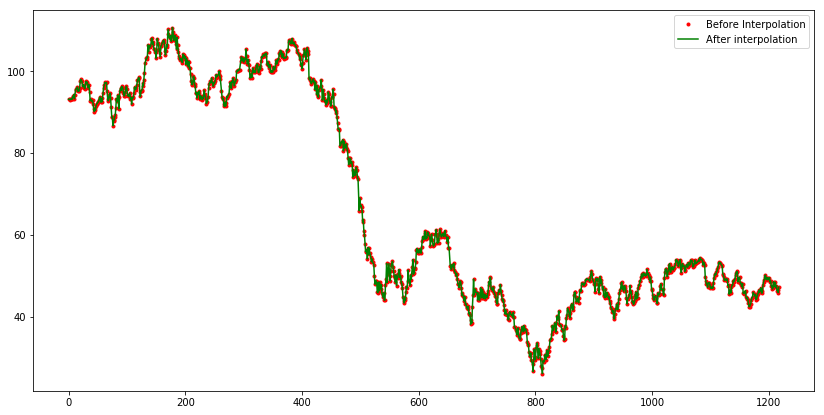

In [22]:
matplotlib.rcParams['figure.figsize'] = [14, 7]
plt.plot(range(len(dcoilwtico)), dcoilwtico.values, "r.", label="Before Interpolation")
plt.plot(range(len(dcoilwtico)), dcoilwtico_nona.values, "g-", label="After interpolation")
plt.legend()
plt.show()

Look great, lets replace `dcoilwtico` in `df_oil` with the interpolated values

In [23]:
df_oil.dcoilwtico = dcoilwtico_nona
dcoilwtico = None

### Merge metadata into core dataframe
Currently, our data is scattered around in different dataframes (`df_oil`, `df_store`, `df_items`, `df_train`). To do machine learning, we need them all to be in one dataframe (`df_train`). Similarly, do the same for `df_test`

##### Merge items dataframe into core dataframe
Merge items dataframe into core dataframe by `item_nbr`

In [24]:
%time df_all_train = pd.merge(df_train, df_items, on="item_nbr")
%time df_all_test = pd.merge(df_test, df_items, on="item_nbr")

CPU times: user 16.6 s, sys: 4 s, total: 20.6 s
Wall time: 20.4 s
CPU times: user 265 ms, sys: 19.8 ms, total: 284 ms
Wall time: 283 ms


In [25]:
# Allow python's GC to reclaim memory
df_train = None
df_test = None
df_items = None
gc.collect()

2593

##### Merge store dataframe into core data frame 
Merge store dataframe into core dataframe by `store_nbr`

In [26]:
%time df_all_train = pd.merge(df_all_train, df_stores, on="store_nbr")
%time df_all_test = pd.merge(df_all_test, df_stores, on="store_nbr")

CPU times: user 14.3 s, sys: 4.42 s, total: 18.7 s
Wall time: 18.7 s
CPU times: user 342 ms, sys: 175 µs, total: 342 ms
Wall time: 341 ms


In [27]:
# Allow python's GC to reclaim memory
df_stores = None
gc.collect()

89

##### Merge oil dataframe into core data frame
Merge `df_oil` dataframe into core by nearest `date`

1. First we sort the dataframes by date

In [28]:
df_all_train.sort_values(by="date", inplace=True)
df_all_test.sort_values(by="date", inplace=True)
df_oil.sort_values(by="date", inplace=True)

2. Perform Merge `df_oil` dataframe into core by nearest backward `date`

In [29]:
%time df_all_train = pd.merge_asof(df_all_train, df_oil, on="date")
%time df_all_test = pd.merge_asof(df_all_test, df_oil, on="date")

CPU times: user 7.59 s, sys: 3.32 s, total: 10.9 s
Wall time: 10.9 s
CPU times: user 200 ms, sys: 22 µs, total: 200 ms
Wall time: 206 ms


In [30]:
# Allow python's GC to reclaim memory
df_oil = None
gc.collect()

134

##### Merge events & holidays dataframe into core dataframe
Merge `df_events` into the core dataframes on `date` column

1. Sort the dataframes by date

In [31]:
df_all_train.sort_values(by="date", inplace=True)
df_all_test.sort_values(by="date", inplace=True)
df_events.sort_values(by="date", inplace=True)

2. Perform Merge `df_events` into the core dataframes on `date` column

In [32]:
%time df_all_train = pd.merge_asof(df_all_train, df_events, on="date")
%time df_all_test = pd.merge_asof(df_all_test, df_events, on="date")

CPU times: user 8.84 s, sys: 4.34 s, total: 13.2 s
Wall time: 13.4 s
CPU times: user 271 ms, sys: 107 ms, total: 378 ms
Wall time: 1.03 s


In [33]:
# Allow python's GC to reclaim memory
df_events = None
gc.collect()

42

### Commit dataset to disk

##### Write preprocessed dataset to disk in feather format

In [34]:
# setup feather cache directory
CACHE_PATH = "tmp/groceries/"
if not os.path.exists(CACHE_PATH): os.makedirs(CACHE_PATH)

# save data frame as feather
df_all_train.to_feather(f"{CACHE_PATH}train.feather")
df_all_test.to_feather(f"{CACHE_PATH}test.feather")